# Stochastic and mini batch gradient descent

## Introduction: batch gradient descent

In all the previous notebooks have solved our optimization problems using the algorithm of (batch) [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). The main idea is that for each iteration we update the parameter of the model moving in the opposite direction of the gradient of the function to optimize. For this, we use all the examples in each iteration. More precisely, let $J = J(\theta; X,y)$ be the cost function as a function of the parameters $\theta$, keeping both the set of features $X$ and target values $y$ fixed. We compute the gradient in vectorized form $\nabla J (\theta;X,y)$ and for each step of the iterative process, we update $\theta = \theta - \alpha\nabla J$, where $\alpha$ is the learning rate. It is a common practice to take a cost function of the form

$$
J(\theta) = \displaystyle \dfrac{1}{m}\sum_{i=1}^m Q(\theta;x^{(i)},y^{(i)})
$$

where $m$ is the number of examples to train the model and $Q$ is a cost function for the each training example. In the least squares methods, 

$$Q(\theta;x^{(i)},y^{(i)})=\frac{1}{2}(x^{(i)}\cdot \theta - y^{(i)})^2,$$

assuming that each training example is augmented with a one at the zero-th coordinate to take into account the bias unit (or the intercept). This cost function $J$ yields then a gradient which is also an average over all the training examples:

$$
\nabla J = \displaystyle \dfrac{1}{m}\sum_{i=1}^m \nabla Q(\theta;x^{(i)},y^{(i)}) = \displaystyle \dfrac{1}{m}\sum_{i=1}^m (\theta\cdot x^{(i)} - y^{(i)} )x^{(i)}.
$$

If our data set has a large number of examples (that is, if $m$ is too large), computing the sums above can be computationally expensive, as for a large data set it might not be possible to hold all the examples in the memory.


## Stochastic and mini batch gradient descent

One alternative to this problem is to compute the averages in $J$ and $\nabla J$ over smaller subsets (batches) of the full data set, and use these to update the parameters $\theta$. In this way, we can hold all the examples of the batch in the memory and make use of the internal linear algebra calculations optimization algorithms of the scientific libraries of python. Strictly speaking, stochastic gradient descent takes the batch size to be $1$, but here we combine the idea of taking a larger batch with the randomization process used by stochastic gradient descent. Thus, we shuffle our data set in every iteration of the algorithm and then go through it updating the parameter with each mini batch.

More precisely: suppose we have $m$ training examples $x^{(1)},\dots,x^{(m)}$ and $m=d\cdot q$, where $d,q\in\mathbb{N}$. Then we can divide the training examples in $q$ groups of size $d$: $\{x^{(kd+i)}:i=1\dots d \}_{k=0}^{q-1}$. For each iteration of the algorithm, we update the parameters $\theta$ using each of the $q$ batches of examples. If we stack the training examples in a matrix $X$ (augmented with a column of ones to take into account the bias unit/intercept of the model) and the target values in a vector $Y$, we can summarize the algorithm as

\begin{align*}
&  \  \text{intialize } \theta \text{ to a random value} \\
&  \ \text{for } i = 1\dots \text{ num iterations do}  \\
&  \qquad \ \text{shuffle data set } \\
&  \qquad \ \text{for } j = 0\dots q-1 \text{ do}  \\
&  \qquad \qquad  \ \text{compute the gradient }\nabla J = \nabla J(\theta; X[:, \ jd,(j+1)d],Y[j,(j+1)d]) \\
&  \qquad \qquad  \ \text{update the parameters }\theta \text{ by } \theta \leftarrow \theta - \alpha\nabla J \\
&  \ \text{return } \theta
\end{align*}

Reporting the training error is slightly more complicated in this case. We stress that later on, we will study the right metrics to evaluate the performance of the models we fit to our data. We use the training error merely to evaluate the convergence to the optimum.

Let us start by importing the scientific libraries we are going to make us of:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random

Now we create a data set to separate using the logistic regression algorithm:

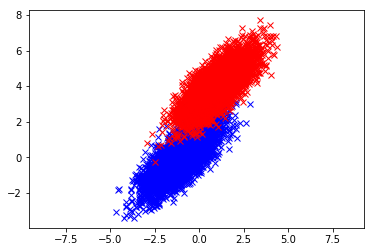

In [2]:
np.random.seed(1)
num_observations = 5000
x0 = np.random.multivariate_normal([-1, 0], [[1, .75],[.75, 1]], num_observations)
x1 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

y0 = np.zeros(len(x0))
y1 = np.ones(len(x1))

X =  np.vstack((x0,x1))
Y = np.append(y0,y1)

fig,ax = plt.subplots()
ax.plot(x0[:,0],x0[:,1],'x',color='blue')
ax.plot(x1[:,0],x1[:,1],'x',color='red')
ax.axis('equal')
plt.show()

## Implementation: batch gradient descent

We now implement the usual batch gradient descent:

In [3]:
def sigmoid(v):
    return 1/(1 + np.exp(-v))

def cost_function(X, Y, theta):
    m = X.shape[0]
    M = np.hstack(((np.ones(X.shape[0])).reshape(-1,1),X))
    h = sigmoid(M.dot(theta))
    J = (1/m)*(-(Y.T).dot(np.log(h)) - ((1-Y).T).dot(np.log(1-h)))
    return J

def gradient(X, Y, theta):
    m = X.shape[0]
    M = np.hstack(((np.ones(X.shape[0])).reshape(-1,1),X))
    return (1/m)*np.array((M.T).dot(sigmoid(M.dot(theta))-Y))

def logistic_regression(X, Y, num_steps, learn_rate):
    theta = 2*np.random.rand(X.shape[1]+1)-1
    C = [] #list of costs
    for i in range(0,num_steps):
        grad = gradient(X,Y,theta)
        theta = theta - learn_rate*np.array(grad)
        if i % 25 == 0:  #We capture the cost every 25 iterations
            C.append(cost_function(X,Y,theta))
    return [theta,C]

We can now use the algorithm to find a line separating the two clouds of data. We also measure the execution time of the algorithm.

In [4]:
startTime = datetime.now()
LRb,LRb_cost = logistic_regression(X,Y,9000,0.03)
print(datetime.now() - startTime)

0:00:03.929482


We can plot now the resulting solution.

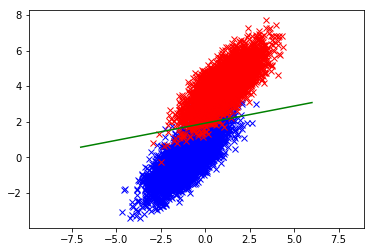

In [5]:
x_range = np.array(range(-7,7))
ax.plot(x_range,-(LRb[0])/LRb[2] - (LRb[1]/LRb[2])*x_range , 'green' )
fig

We can also plot the cost as a function of the number of iterations. 

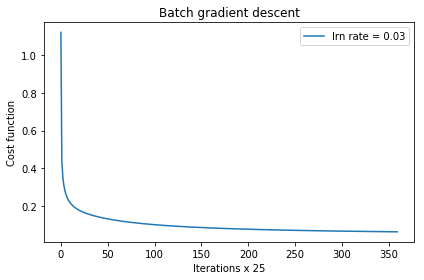

In [6]:
plt.plot(range(len(LRb_cost)),LRb_cost)
plt.title('Batch gradient descent')
plt.xlabel('Iterations x 25')
plt.ylabel('Cost function')
plt.legend(['lrn rate = 0.03'])
axes = plt.gca()

plt.tight_layout()
plt.show()

We can see that after around $200\times 25 = 5000$ iterations, the cost function stabilizes and we can stop the algorithm after we this point. Let us calculate the time the algorithm takes to reach this point. We also compute the cost function evaluated at the parameters found by the algorithm.

In [7]:
startTime = datetime.now()
LRb,LRb_cost = logistic_regression(X,Y,5000,0.03)
print(datetime.now() - startTime)
print(cost_function(X,Y,LRb))

0:00:02.412267
0.07721787665851107


We plot again the cost as a function of the number of iterations.

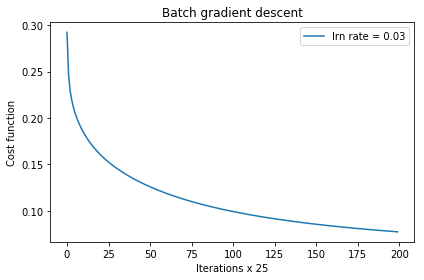

In [8]:
plt.plot(range(len(LRb_cost)),LRb_cost)
plt.title('Batch gradient descent')
plt.xlabel('Iterations x 25')
plt.ylabel('Cost function')
plt.legend(['lrn rate = 0.03'])
axes = plt.gca()

plt.tight_layout()
plt.show()

## Implementation: mini batch gradient descent

Now we implement the batch gradient descent. The parameters of the algorithm are the number of iterations, the learning rate and the size of the batch.

In [9]:
def mini_batch_regression(X, Y, num_steps, learn_rate,batch_size):
    theta = 2*np.random.rand(X.shape[1]+1)-1
    C = []
    d = batch_size
    q = int(X.shape[0]/d)
    shuffle = list(range(X.shape[0]))
    for i in range(num_steps):
        random.shuffle(shuffle)
        Z = X[shuffle]
        W = Y[shuffle]
        for j in range(q):
            grad = gradient(Z[d*j:d*(j+1),:],W[d*j:d*(j+1)],theta)
            theta = theta - learn_rate*np.array(grad)
        C.append(cost_function(X,Y,theta))
    return [theta,C]

Now we proceed to run the algorithm. We choose the size of the batch to be $20$, so there are $250$ batches for each iteration. We keep the learning rate equal to $0.03$ and set the number of iterations to $15$. We also time the execution of the algorithm.

In [10]:
startTime = datetime.now()
MBR,MBR_cost = mini_batch_regression(X,Y,15,0.03,20)
print(datetime.now() - startTime)
print(cost_function(X,Y,MBR))

0:00:00.454013
0.0670307253140449


Now we plot the resulting separating line as well as the cost curve as a function of iterations. The separating line produced by SGD is plotted in purple and the line produced by batch GD is plotted in green.

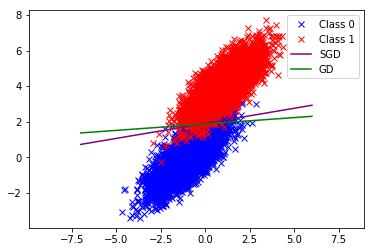

In [11]:
fig,ax = plt.subplots()
ax.plot(x0[:,0],x0[:,1],'x',color='blue')
ax.plot(x1[:,0],x1[:,1],'x',color='red')
#plt.figtext(0.5, 0.01, 'Figure 2: data separated by our predicted line.', 
#            wrap=True, horizontalalignment='center', fontsize=12)
ax.axis('equal')
x_range = np.array(range(-7,7))
ax.plot(x_range,-(MBR[0])/MBR[2] - (MBR[1]/MBR[2])*x_range , 'purple' )
ax.plot(x_range,-(LRb[0])/LRb[2] - (LRb[1]/LRb[2])*x_range , 'green' )
plt.legend(['Class 0', 'Class 1','SGD','GD'])
plt.show()

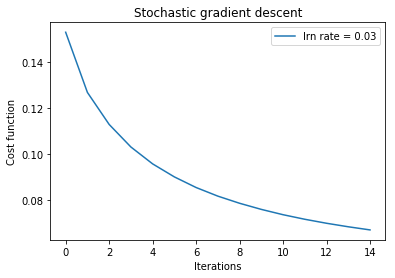

In [12]:
plt.plot(range(len(MBR_cost)),MBR_cost)
plt.title('Stochastic gradient descent')
plt.xlabel('Iterations')
plt.ylabel('Cost function')
plt.legend(['lrn rate = 0.03'])
axes = plt.gca()

plt.show()

We can see how our implementation of stochastic gradient descent achieves a lower cost in a fraction of the time that it takes batch gradient descent to find a less optimal solution. We conclude this notebook by remarking that even though the cost function we used has very good convexity properties (making it easier for the algorithms to find the optimum), in general SGD outperforms batch gradient descent.